In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests
import re
import time
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from urllib import parse
from wordcloud import WordCloud

**------완성된 프로그램 (3번째 cell)------**

이 프로그램은 원하는 영화의 url이 주어지면 해당 영화에 대해 여러 명의 평론가 쓴 평가를 요약하는 워드클라우드를 그려줌니다.

< (코드 설명 및 프로그램 제작 과정 아레에 참고 (5번째 cell부터) >

In [2]:
headers = {
    'Referer': 'https://www.rottentomatoes.com/m/notebook/reviews?type=user',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
    }

s = requests.Session()

def get_movieID(url):
    r = requests.get(url)
    movieID = re.findall(r'(?<=movieId":")(.*)(?=","type)',r.text)[0]
    return movieID


def get_critics_reviews(url):    

    movieID = get_movieID(url)
    
    api_url = f"https://www.rottentomatoes.com/napi/movie/{movieID}/criticsReviews/all" 
    
    
    payload = {
        'direction': 'next',
        'endCursor': '',
        'startCursor': '',
    }
    
    review_data = []
    
    while True:
        r = s.get(api_url, headers=headers, params=payload)
        data = r.json()

        if not data['pageInfo']['hasNextPage']: 
            break
            
        payload['endCursor'] = data['pageInfo']['endCursor']
        payload['startCursor'] = data['pageInfo']['startCursor'] if data['pageInfo'].get('startCursor') else ''

        review_data.extend(data['reviews'])
        time.sleep(1)
    
    return review_data


def tokenize(document):
    lemma = WordNetLemmatizer().lemmatize
    tokens = [lemma(w) for w in document.split() if len(w) > 3 and w.isalpha()]
    return tokens

def data_processing(url):
    data = get_critics_reviews(url)
    df = pd.json_normalize(data)
    df['quote_clean'] = df['quote'].map(lambda x: re.sub(r'[^a-zA-Z ] ', ' ', str(x)))
    stop_w = stopwords.words('english') + ['make', 'feel', 'take','also', 'every', 'would', 'could','might', 'may', 'review', 'something', 'anything', 'going', 'despite','mostly','get', 'movie', 'film','still','many','thing', 'through', 'throughout', 'without', 'ever', 'anyone', 'actually', 'totally', 'much', 'really','surely', 'since', 'even']
    vectorizer = TfidfVectorizer(tokenizer = tokenize, ngram_range = ((1,1)), stop_words = stop_w, strip_accents = 'unicode')
    
    
    tdmx = vectorizer.fit_transform(df['quote_clean']) 
    tfidf_weights = [(word, tdmx.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
    return tfidf_weights
    
def word_cloud(url):
    tfidf_weights = data_processing(url)
    wc = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=200).fit_words(dict(tfidf_weights))
    
    plt.figure(figsize=(20,15))
    plt.axis('off')
    plt.imshow(wc)

C:\Users\lucal\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


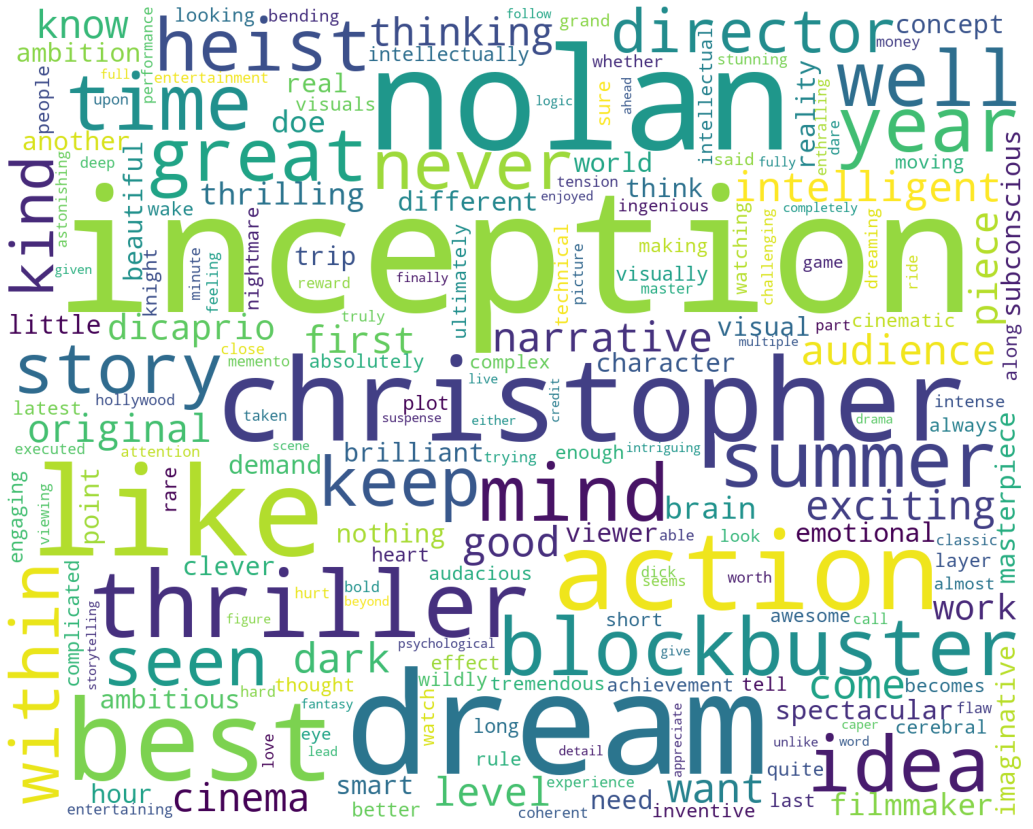

In [3]:
#'Inception' 영화를 이용한 예시 
word_cloud('https://www.rottentomatoes.com/m/inception/reviews') #url format: Rotten Tomatoes에서 해당 영화 페이지 + 끝에 '/reviews'를 포함해야 함
##even though a warning may appear in certain cases, it has been verified that the stop words list is being properly applied

**< (여기부터는 코드 설명 및 프로그램 제작 과정입니다) >**

In [4]:
#use most recent Chrome user agent and referer make it seem as if the request came from someone already navigating inside the Rotten Tomatoes website
headers = {
    'Referer': 'https://www.rottentomatoes.com/m/notebook/reviews?type=user',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
    }

s = requests.Session() #initialize a session (and keep cookies)


#get from the movie page the movie ID which will be used to access the api URL for the desired movie
def get_movieID(url):
    r = requests.get(url)
    movieID = re.findall(r'(?<=movieId":")(.*)(?=","type)',r.text)[0] #retrieve movie ID from inside the page source code
    return movieID

#scrapping reviews through Rotten Tomatoes API
def get_critics_reviews(url):    

    movieID = get_movieID(url)
    
    #use the obtained movieID to access the api_url for the desired movie
    api_url = f"https://www.rottentomatoes.com/napi/movie/{movieID}/criticsReviews/all" 
    
    #Rotten Tomates API uses Cursor-based Pagination (Graph API) 
    #set endCursor and startCursor as empty strings for the first iteration
    payload = {
        'direction': 'next',
        'endCursor': '',
        'startCursor': '',
    }
    
    review_data = []
    
    while True: #loop api requests until the last page and crawl all the reviews  
        r = s.get(api_url, headers=headers, params=payload)
        data = r.json()

        if not data['pageInfo']['hasNextPage']: #stop loop when hasNextPage not true
            break
        #update 'endCursor' and 'startCursor' values
        payload['endCursor'] = data['pageInfo']['endCursor']
        payload['startCursor'] = data['pageInfo']['startCursor'] if data['pageInfo'].get('startCursor') else ''

        review_data.extend(data['reviews'])
        time.sleep(1) # wait for 1s between each loop
    
    return review_data

In [5]:
data = get_critics_reviews('https://www.rottentomatoes.com/m/inception/reviews') #url format: Rotten Tomatoes에서 해당 영화 페이지 + 끝에 '/reviews'를 포함해야 함
df = pd.json_normalize(data) #load the obtained data with Pandas

In [6]:
df['quote'] #check the obtained data

0      It's not nearly as confusing as many make it o...
1      Inception engaged on a mainly intellectually l...
2      "They say we only use a fraction of our brain'...
3      Inception is an intriguing, frustrating film, ...
4      Mind-blowing doesn't even begin to describe di...
                             ...                        
355    I expected a lot,but still walked out hypnotiz...
356    A wildly entertaining and dazzling mind-trip n...
357    If movies are shared dreams, then Christopher ...
358    A devilishly complicated, fiendishly enjoyable...
359    Inception is a masterpiece. Making a huge film...
Name: quote, Length: 360, dtype: object

In [7]:
df['quote'].isnull().sum() #check for null values on the 'quotes' column

0

In [8]:
text = " ".join(review for review in df['quote'].astype(str))
print ("There are {} words in total in the 'quote' column.".format(len(text)))

There are 50460 words in total in the 'quote' column.


In [9]:
#use regex to match all strings that contain a non-letter,remove them and save results into 'quotes clean'
df['quote_clean'] = df['quote'].map(lambda x: re.sub(r'[^a-zA-Z ] ', ' ', str(x)))

In [10]:
#define stopwords by using the list of top stopwords provided by NLTK + some words that are often used on movie reviews but are not relevant 
stop_w = stopwords.words('english') + ['make', 'feel', 'take','also', 'every', 'would', 'could','might', 'may', 'review', 'something', 'anything', 'going', 'despite','mostly','get', 'movie', 'film','still','many','thing', 'through', 'throughout', 'without', 'ever', 'anyone', 'actually', 'totally', 'much', 'really','surely', 'since', 'even']
print(stop_w)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
lemma = WordNetLemmatizer().lemmatize
lemma('makes') #testing lemmatization

'make'

In [12]:
def tokenize(document):
    tokens = [lemma(w) for w in document.split() if len(w) > 3 and w.isalpha()] #apply lemmatizer to words longer than 3 characters
    return tokens

In [13]:
#TF-IDF Vectorizer
#tokenizer set to use the tokenize function defined above, stop_words uses the stop words defined above
#ngram_range adjusted for single words (unigrams)
#strip_accents removes accents and perform other character normalization
#additionally, max-df parameter can be used to ignore terms whose document frequency is greater than a selected threshold. This can be used for preventing the movie title from appearing on the word cloud, if so desired 
vectorizer = TfidfVectorizer(tokenizer = tokenize, ngram_range = ((1,1)), stop_words = stop_w, strip_accents = 'unicode')

In [14]:
tdmx = vectorizer.fit_transform(df['quote_clean']) #apply TF-IDF Vectorizer
#even though a warning may appear in certain cases, it was verified that the stop words used are being properly applied

In [15]:
#Prepare TF-IDF Matrix for word cloud
tfidf_weights = [(word, tdmx.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

In [16]:
tfidf_weights[0:10] #checking

[('nearly', 1.017710444562266),
 ('confusing', 0.7238096889748427),
 ('find', 0.9212856009095793),
 ('losing', 0.8392551682361474),
 ('plot', 1.7365901161706694),
 ('remember', 0.38918242189728774),
 ('overwhelm', 0.38918242189728774),
 ('part', 1.28325737166737),
 ('inception', 15.660520205787066),
 ('engaged', 0.45261393791687904)]

In [17]:
#create word cloud using WordCloud for Python
wc = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=200).fit_words(dict(tfidf_weights))

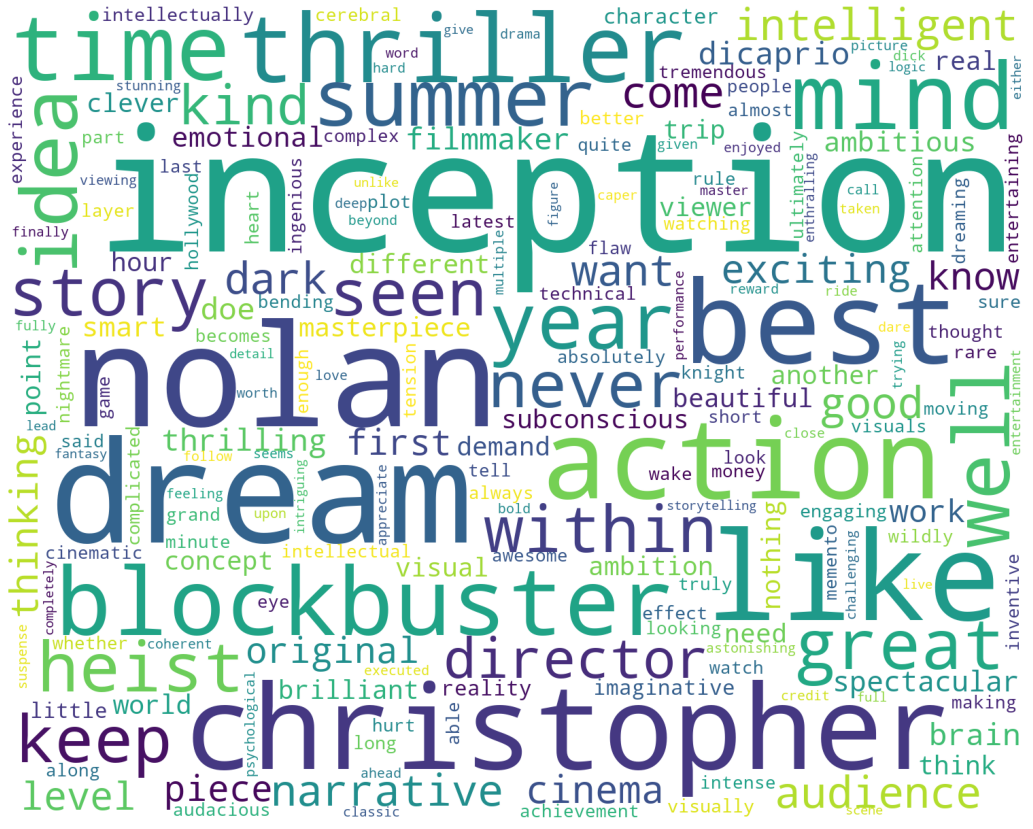

In [18]:
#show word cloud
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

# plt.savefig('movie_wordcloud.png')